In [1]:
import os
import torch
import numpy as np
import wandb

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from models.resnet_depth_unet import ResnetDepthUnet
from utils.dataloader import TraversabilityDataset

import matplotlib.pyplot as plt

%matplotlib inline

c:\Users\deeks\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialization

In [2]:
class Object(object):
    pass

params = Object()
# dataset parameters
params.data_path        = r'C:/Users/deeks/Documents/WayFAST/myfile/data'
params.csv_path         = os.path.join(params.data_path, 'data.csv')
params.preproc          = True  # Vertical flip augmentation
params.depth_mean       = 3.5235
params.depth_std        = 10.6645

# training parameters
params.seed             = 230
params.epochs           = 50
params.batch_size       = 16
params.learning_rate    = 1e-4
params.weight_decay     = 1e-5

# model parameters
params.pretrained = True
params.load_network_path = None 
params.input_size       = (424, 240)
params.output_size      = (424, 240)
params.output_channels  = 1
params.bottleneck_dim   = 256

In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="LIR_project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": params.learning_rate,
    "architecture": "ResnetDepthUnet",
    "dataset": "WayFAST",
    "epochs": params.epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: deesethi. Use `wandb login --relogin` to force relogin


In [4]:
torch.manual_seed(params.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(params.seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [5]:
net = ResnetDepthUnet(params)

# use to load a previously trained network
if params.load_network_path is not None:
    print('Loading saved network from {}'.format(params.load_network_path))
    net.load_state_dict(torch.load(params.load_network_path))

print("Let's use", torch.cuda.device_count(), "GPUs!")
net = torch.nn.DataParallel(net).to(device)

c:\Users\deeks\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\deeks\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's use 1 GPUs!


In [6]:
test = net(torch.rand([2, 3, params.input_size[1], params.input_size[0]]).to(device), torch.rand([2, 1, params.input_size[1], params.input_size[0]]).to(device))
print('test.shape:', test.shape)

test.shape: torch.Size([2, 1, 240, 424])


In [7]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

dataset = TraversabilityDataset(params, transform)

train_size, val_size = int(0.8*len(dataset)), np.ceil(0.2*len(dataset)).astype('int')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader    = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)
test_loader     = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)

print('Total loaded %d images' % len(dataset))
print('Loaded %d train images' % train_size)
print('Loaded %d valid images' % val_size)

Initializing dataset
Depth mean: 3.438056670303481
Depth std: 10.458746256918245
Total loaded 16558 images
Loaded 13246 train images
Loaded 3312 valid images


In [8]:
data = train_dataset[0]

## Set up training tools

In [9]:
criterion = torch.nn.L1Loss(reduction='none')
optimizer = torch.optim.Adam(net.parameters(), lr=params.learning_rate, weight_decay=params.weight_decay)

## Train detector

Epoch 1
Epoch [1/50], Loss:  0.008825184786939715
Learning Rate for this epoch: 0.0001
Updating best validation loss: 0.00848
Epoch 2
Updating best validation loss: 0.00708
Epoch 3
Epoch 4
Updating best validation loss: 0.00635
Epoch 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


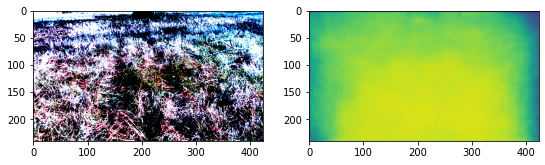

Updating best validation loss: 0.00616
Epoch 6
Updating best validation loss: 0.00616
Epoch 7
Epoch 8
Updating best validation loss: 0.00591
Epoch 9
Epoch 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


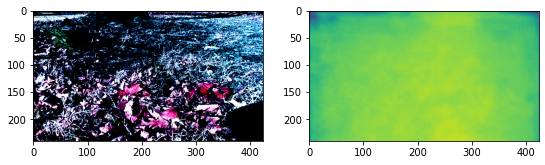

Updating best validation loss: 0.00573
Epoch 11
Epoch [11/50], Loss:  0.005916789482271182
Learning Rate for this epoch: 0.0001
Epoch 12
Epoch 13
Updating best validation loss: 0.00555
Epoch 14
Updating best validation loss: 0.00543
Epoch 15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


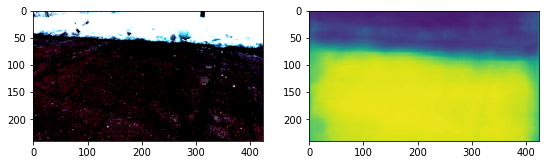

Epoch 16
Updating best validation loss: 0.00529
Epoch 17
Epoch 18
Updating best validation loss: 0.00524
Epoch 19
Updating best validation loss: 0.00517
Epoch 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


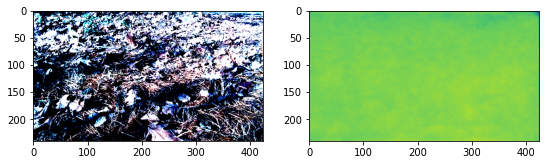

Updating best validation loss: 0.00501
Epoch 21
Epoch [21/50], Loss:  0.005161476152378769
Learning Rate for this epoch: 0.0001
Epoch 22
Epoch 23
Epoch 24
Epoch 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


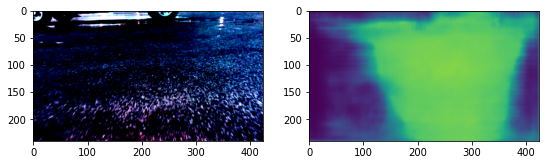

Epoch 26
Epoch 27
Updating best validation loss: 0.00496
Epoch 28
Updating best validation loss: 0.00490
Epoch 29
Updating best validation loss: 0.00470
Epoch 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


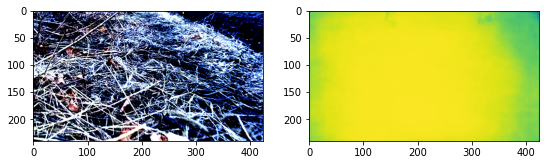

Epoch 31
Epoch [31/50], Loss:  0.004599399771738195
Learning Rate for this epoch: 0.0001
Epoch 32
Updating best validation loss: 0.00464
Epoch 33


In [10]:
best_val_loss = np.inf
train_loss_list = []
val_loss_list = []
for epoch in range(params.epochs):
    print('Epoch %d' % (epoch+1))
    net.train()    
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        data = (item.to(device).type(torch.float32) for item in data)
        color_img, depth_img, path_img, mu_img, nu_img, weight = data

        pred = net(color_img, depth_img)

        label = mu_img

        loss = weight*criterion(pred*path_img, label)
        loss = torch.mean(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)
    wandb.log({"train_loss": train_loss})
    train_loss_list.append(train_loss)
        
    if (epoch) % 10 == 0:
        outstring = 'Epoch [%d/%d], Loss: ' % (epoch+1, params.epochs)
        print(outstring, train_loss)
        print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))
    
    # evaluate the network on the test data
    with torch.no_grad():
        val_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device).type(torch.float32) for item in data)
            color_img, depth_img, path_img, mu_img, nu_img, weight = data

            pred = net(color_img, depth_img)

            label = mu_img

            loss = weight*criterion(pred*path_img, label)
            loss = torch.mean(loss)

            val_loss += loss.item()
        val_loss /= len(test_loader)
        wandb.log({"val_loss": val_loss})
        val_loss_list.append(val_loss)

    if (epoch + 1) % 5 == 0:
        plt.figure(figsize = (14,14))
        plt.subplot(1, 3, 1)
        plt.imshow(color_img[0].permute(1, 2, 0).cpu().numpy())
        plt.subplot(1, 3, 2)
        plt.imshow(255*pred[0,0,:,:].detach().cpu().numpy(), vmin=0, vmax=255)
        plt.show(block=False)
    
    if best_val_loss > val_loss:
        best_val_loss = val_loss
        print('Updating best validation loss: %.5f' % best_val_loss)
        torch.save(net.module.state_dict(),'checkpoints/best_predictor_depth.pth')

    torch.save(net.module.state_dict(),'checkpoints/predictor_depth.pth')

wandb.finish()